In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
import json

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from torch.utils.data import DataLoader, TensorDataset,DataLoader,Dataset, random_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from gensim.models import Word2Vec

In [ ]:
# 1. 데이터 로드
input_ids = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')
train_word = pd.read_csv('/content/drive/MyDrive/challenge_log_data/only_word_train')
test_word =pd.read_csv('/content/drive/MyDrive/challenge_log_data/only_word_test')
val = pd.read_csv('/content/drive/MyDrive/challenge_log_data/validation_sample.csv')
EDA_Oversampling = pd.read_csv('/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv')

## Bert Autoencoder

In [ ]:


# 데이터 전처리
max_length = input_ids.shape[1]  # 벡터 길이 추출
scaled_sequences = input_ids.numpy()
#minmax scaler

scaler = MinMaxScaler()
scaled_sequences = scaler.fit_transform(scaled_sequences)
train_data, val_data = train_test_split(scaled_sequences, test_size=0.2, random_state=42)



In [ ]:
# 2. Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:

# 3. 하이퍼파라미터 설정
input_dim = max_length
hidden_dim = 64
batch_size = 32
num_epochs = 30
learning_rate = 0.001
threshold = 0.05
patience = 5

In [ ]:
# 데이터를 PyTorch 텐서로 변환
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)


In [ ]:
# 데이터로더 생성
train_dataset = TensorDataset(train_tensor, train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_tensor, val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:

# 모델 초기화
model = Autoencoder(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:

# Early stopping 변수 초기화
best_val_loss = float('inf')
counter = 0

In [ ]:
# 학습 루프
for epoch in range(num_epochs):
    model.train()
    for batch_data, _ in train_loader:
        # 순전파
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 검증 데이터에 대한 평가
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_data, _ in val_loader:
            outputs = model(batch_data)
            batch_loss = criterion(outputs, batch_data)
            val_loss += batch_loss.item()
        val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch [1/30], Train Loss: 0.0455, Val Loss: 0.0402
Epoch [2/30], Train Loss: 0.0433, Val Loss: 0.0372
Epoch [3/30], Train Loss: 0.0421, Val Loss: 0.0358
Epoch [4/30], Train Loss: 0.0430, Val Loss: 0.0352
Epoch [5/30], Train Loss: 0.0416, Val Loss: 0.0345
Epoch [6/30], Train Loss: 0.0375, Val Loss: 0.0339
Epoch [7/30], Train Loss: 0.0376, Val Loss: 0.0335
Epoch [8/30], Train Loss: 0.0360, Val Loss: 0.0336
Epoch [9/30], Train Loss: 0.0393, Val Loss: 0.0330
Epoch [10/30], Train Loss: 0.0453, Val Loss: 0.0330
Epoch [11/30], Train Loss: 0.0403, Val Loss: 0.0326
Epoch [12/30], Train Loss: 0.0376, Val Loss: 0.0326
Epoch [13/30], Train Loss: 0.0403, Val Loss: 0.0326
Epoch [14/30], Train Loss: 0.0473, Val Loss: 0.0323
Epoch [15/30], Train Loss: 0.0349, Val Loss: 0.0324
Epoch [16/30], Train Loss: 0.0403, Val Loss: 0.0320
Epoch [17/30], Train Loss: 0.0416, Val Loss: 0.0321
Epoch [18/30], Train Loss: 0.0409, Val Loss: 0.0321
Epoch [19/30], Train Loss: 0.0441, Val Loss: 0.0324
Epoch [20/30], Train 

In [ ]:
# 4. 레벨 7 데이터 분류
model.eval()
with torch.no_grad():
    reconstructed_data = model(torch.tensor(scaled_sequences, dtype=torch.float32))
    mse_losses = torch.mean((torch.tensor(scaled_sequences, dtype=torch.float32) - reconstructed_data)**2, dim=1)
    level_7_mask = mse_losses > threshold
    level_7_indices = torch.where(level_7_mask)[0]

# 테스트 데이터프레임에 레벨 7 컬럼 추가
test_df = pd.DataFrame({'full_log': input_ids.numpy().tolist()})
test_df['is_level_7'] = False
test_df.loc[level_7_indices.numpy(), 'is_level_7'] = True

# 레벨 7로 분류된 데이터 출력
level_7_data = test_df[test_df['is_level_7']]['full_log']
print("Level 7 data:")
print(level_7_data)

Level 7 data:
0        [101, 2334, 15006, 2102, 11382, 19445, 2828, 2...
29       [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
35       [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
36       [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
40       [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
                               ...                        
59688    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59697    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59701    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59702    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59704    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
Name: full_log, Length: 10789, dtype: object


##  Autoencoder LOF

In [ ]:
# 레벨 7 데이터 제외한 정상 데이터만 사용
normal_data = np.delete(scaled_sequences, level_7_indices.numpy(), axis=0)

In [ ]:
# PCA를 사용하여 차원 축소
pca = PCA(n_components=2)
pca.fit(normal_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("차원 수:", d)
normal_data_pca = pca.fit_transform(normal_data)

차원 수: 1


In [ ]:
# LOF를 사용한 이상치 검출 및 시각화 함수 정의
def plot_lof_outliers(data, n_neighbors, title):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    y_pred = lof.fit_predict(data)
    outliers = data[y_pred == -1]
    normals = data[y_pred != -1]

    plt.figure(figsize=(10, 6))
    plt.scatter(normals[:, 0], normals[:, 1], label='Normal Data', alpha=0.5)
    plt.scatter(outliers[:, 0], outliers[:, 1], label='Anomaly Data', alpha=0.5, color='r')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

    return y_pred, lof.negative_outlier_factor_


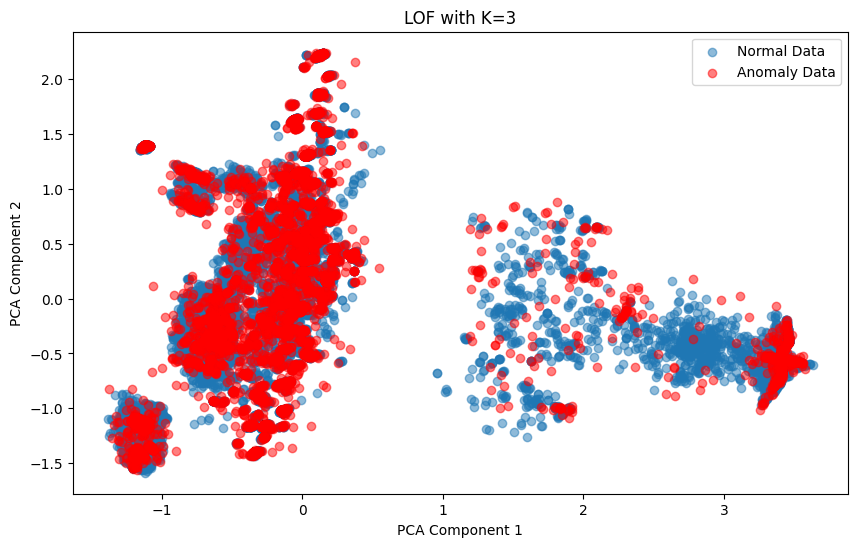

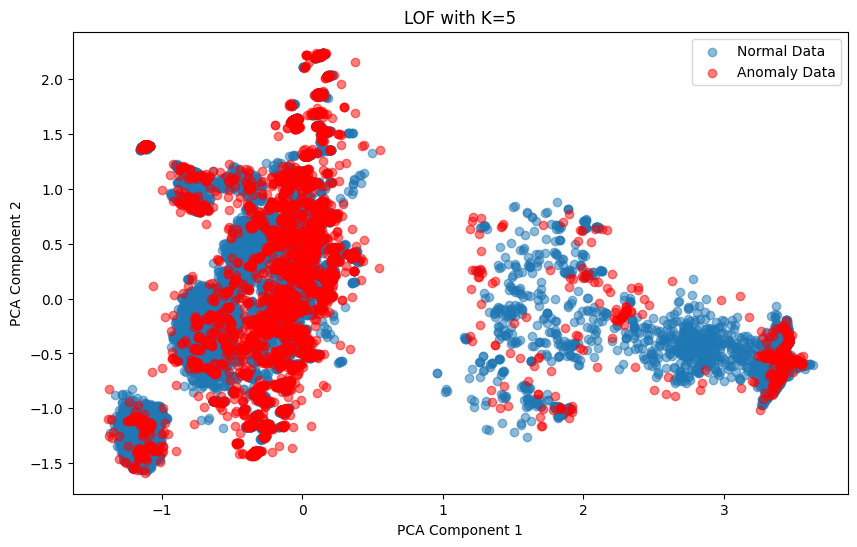

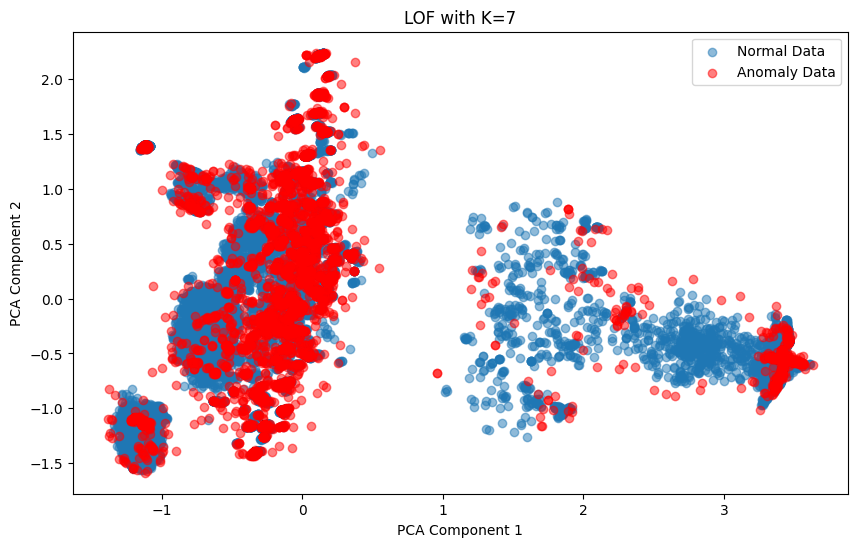

In [ ]:
# K=3, 5, 7에 대해 각각 시각화 및 이상치 검출
lof_results = {}
for k in [3, 5, 7]:
    y_pred, negative_outlier_factors = plot_lof_outliers(normal_data_pca, n_neighbors=k, title=f'LOF with K={k}')
    lof_results[k] = {'y_pred': y_pred, 'negative_outlier_factors': negative_outlier_factors}


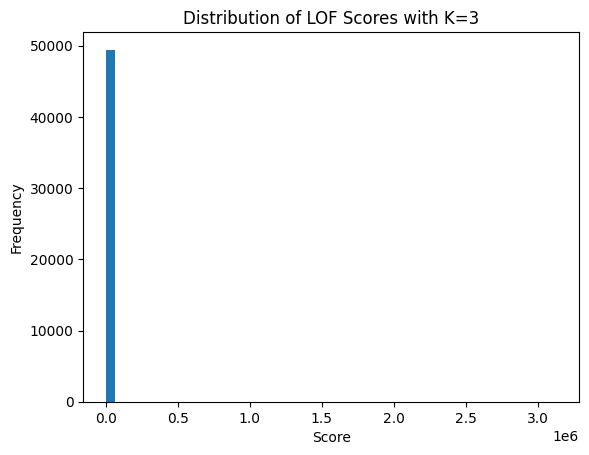

Optimal threshold for K=3: 83.50070445699531


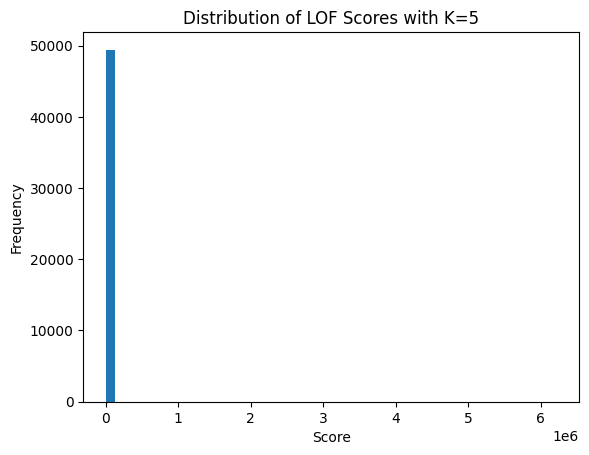

Optimal threshold for K=5: 55.346840468471704


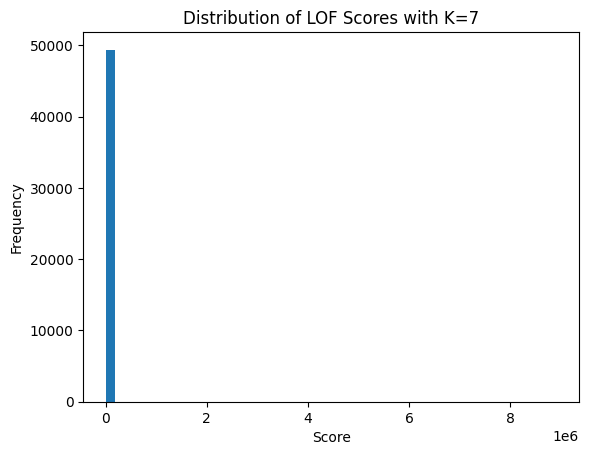

Optimal threshold for K=7: 52.68250120942166


In [ ]:
# 분포 확인 및 최적 임계값 설정
optimal_thresholds = {}
for k in [3, 5, 7]:
    scores = -lof_results[k]['negative_outlier_factors']  # LOF의 negative_outlier_factor_는 음수 값이므로 부호 변경
    plt.hist(scores, bins=50)
    plt.title(f'Distribution of LOF Scores with K={k}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

    # 상위 5%를 이상치로 설정
    threshold = np.percentile(scores, 98.5)
    optimal_thresholds[k] = threshold
    print(f'Optimal threshold for K={k}: {threshold}')

In [ ]:
# DataFrame 생성 및 이상치를 level_7로 분류하여 저장
test_df = pd.DataFrame({'full_log': input_ids.numpy().tolist()})


In [ ]:
for k in [3, 5, 7]:
    test_df[f'is_level_7_k{k}'] = False
    if lof_results[k] is not None:
        scores = -lof_results[k]['negative_outlier_factors']
        test_df.loc[test_df.index[:len(scores)], f'is_level_7_k{k}'] = scores > optimal_thresholds[k]


In [ ]:
test_df['is_level_7_k3'].value_counts()

is_level_7_k3
False    59051
True       740
Name: count, dtype: int64

In [ ]:
test_df['is_level_7_k5'].value_counts()

is_level_7_k5
False    59049
True       742
Name: count, dtype: int64

In [ ]:
test_df['is_level_7_k7'].value_counts()

is_level_7_k7
False    59049
True       742
Name: count, dtype: int64

In [ ]:
# CSV 파일로 저장
for k in [3, 5, 7]:
    output_csv = f'/content/drive/MyDrive/challenge_log_data/lof_results_k{k}.csv'
    test_df[['full_log', f'is_level_7_k{k}']].to_csv(output_csv, index=False)
    print(f'Saved {output_csv}')

Saved /content/drive/MyDrive/challenge_log_data/lof_results_k3.csv
Saved /content/drive/MyDrive/challenge_log_data/lof_results_k5.csv
Saved /content/drive/MyDrive/challenge_log_data/lof_results_k7.csv


In [ ]:
final = pd.read_csv('/content/drive/MyDrive/challenge_log_data/lof_results_k7.csv')
final.head()

,full_log,is_level_7_k7
0,"[101, 2334, 15006, 2102, 11382, 19445, 2828, 2...",False
1,"[101, 2334, 15006, 2102, 15664, 10230, 2232, 1...",False
2,"[101, 4127, 7274, 9289, 2140, 11721, 21041, 21...",False
3,"[101, 4127, 7274, 9289, 2140, 11721, 21041, 21...",False
4,"[101, 2334, 15006, 2102, 15664, 10230, 2232, 1...",False


In [ ]:
from ast import literal_eval
# EDA_Oversampling 데이터에서 full_log 컬럼 로드
train = pd.read_csv('/content/drive/MyDrive/challenge_log_data/train.csv')


##  IF

In [ ]:
# MinMax 스케일링
scaler = MinMaxScaler()
scaled_sequences = scaler.fit_transform(scaled_sequences)
train_data, val_data = train_test_split(scaled_sequences, test_size=0.2, random_state=42)


In [ ]:
def custom_scorer(estimator, X):
    y_pred = estimator.fit(X).predict(X)
    y_true = np.zeros_like(y_pred)  # Assuming all data is normal for scoring purposes
    return f1_score(y_true, y_pred, average='macro')

In [ ]:
param_grid = {'n_estimators': [50, 100, 150, 200, 250]}
if_model = IsolationForest(contamination='auto', random_state=42)
grid_search = GridSearchCV(if_model, param_grid, cv=5, scoring=make_scorer(custom_scorer))
grid_search.fit(train_data)
best_model = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

In [ ]:
# IF score 계산
if_scores = best_model.decision_function(scaled_sequences)
y_pred = best_model.predict(scaled_sequences)

# 이상치 데이터 식별
outlier_mask = y_pred == -1

In [ ]:
# PCA를 사용하여 차원 축소 (2D 시각화)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_sequences)

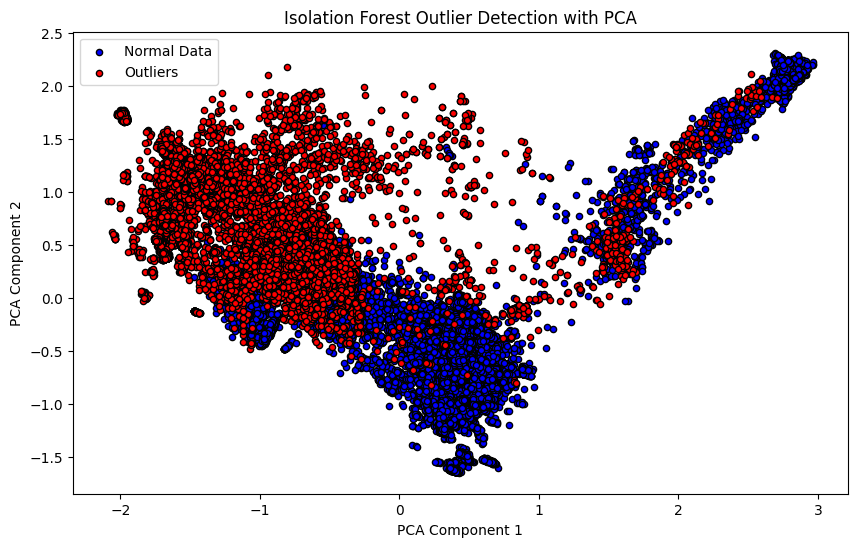

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[~outlier_mask, 0], X_pca[~outlier_mask, 1], c='blue', edgecolor='k', s=20, label='Normal Data')
plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], c='red', edgecolor='k', s=20, label='Outliers')
plt.title('Isolation Forest Outlier Detection with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [ ]:
level_7_indices = np.where(outlier_mask)[0]

# 6. 테스트 데이터프레임에 레벨 7 컬럼 추가
test_df = pd.DataFrame({'full_log': input_ids.numpy().tolist()})
test_df['is_level_7'] = False
test_df.loc[level_7_indices, 'is_level_7'] = True


In [ ]:
test_df['is_level_7'].value_counts()

is_level_7
False    58894
True       897
Name: count, dtype: int64

In [ ]:
# 7. 레벨 7로 분류된 데이터 출력
level_7_data = test_df[test_df['is_level_7']]['full_log']
print("Level 7 data:")
print(level_7_data)

Level 7 data:
48       [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
52       [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
61       [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
116      [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
223      [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
                               ...                        
59623    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59627    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59638    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59654    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
59660    [101, 4127, 7274, 9289, 2140, 11721, 21041, 21...
Name: full_log, Length: 2758, dtype: object


In [ ]:
input_ids = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')

In [ ]:
# MinMax 스케일링
data = input_ids.numpy()
scaler = MinMaxScaler()
scaled_data  = scaler.fit_transform(data)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data)

In [ ]:
# LOF로 이상치 탐지 및 시각화
def plot_lof_outliers(data, n_neighbors, title):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    y_pred = lof.fit_predict(data)

    # LOF의 음수 인덱스를 이상치로 간주
    outliers = data[y_pred == -1]
    normals = data[y_pred != -1]

    plt.figure(figsize=(10, 6))
    plt.scatter(normals[:, 0], normals[:, 1], label='Normal Data', alpha=0.5)
    plt.scatter(outliers[:, 0], outliers[:, 1], label='Anomaly Data', alpha=0.5, color='r')
    plt.title(f'LOF Outliers with n_neighbors={n_neighbors}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()



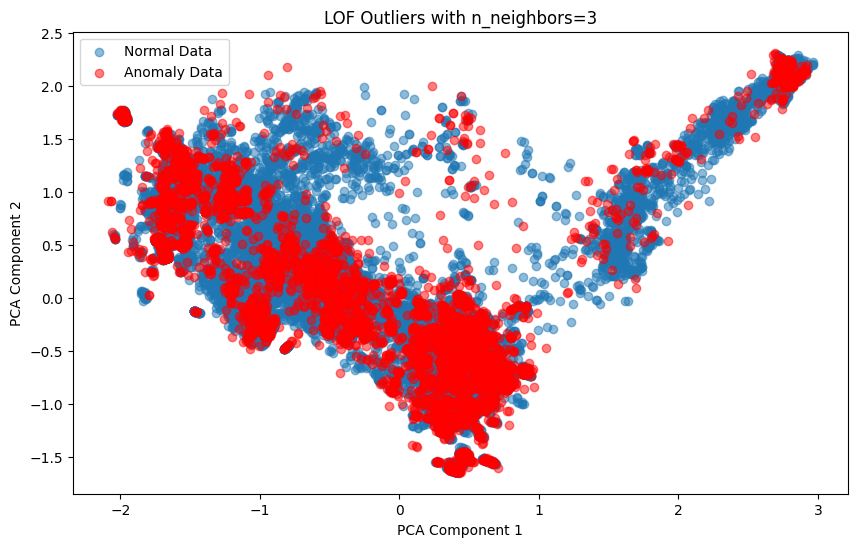

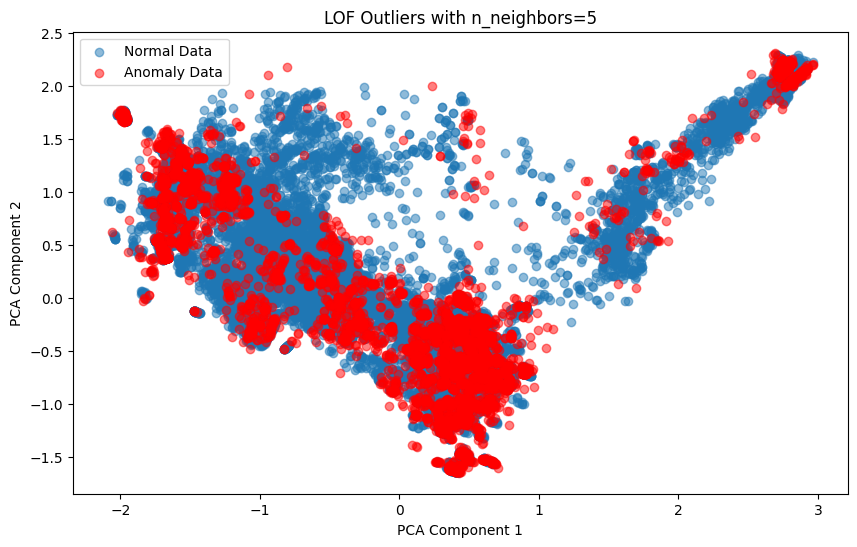

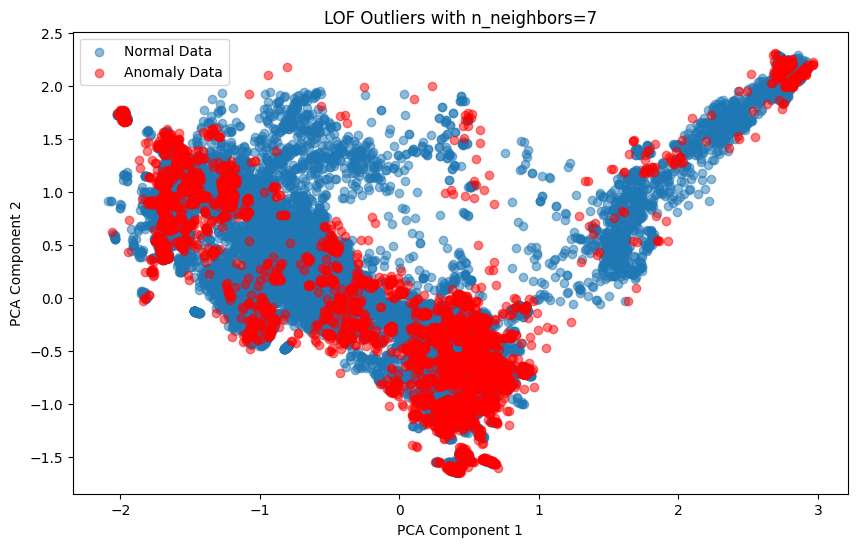

In [ ]:

# K=3, 5, 7에 대해 각각 시각화
plot_lof_outliers(X_pca, n_neighbors=3, title='LOF with K=3')
plot_lof_outliers(X_pca, n_neighbors=5, title='LOF with K=5')
plot_lof_outliers(X_pca, n_neighbors=7, title='LOF with K=7')

## Deep svdd


In [ ]:
train_embeddings = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')
train_labels_df = pd.read_csv('/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv')
test_embeddings = torch.load('/content/drive/MyDrive/challenge_log_data/input_ids.pt')

In [ ]:
train_embeddings_np = train_embeddings.numpy()
train_labels = train_labels_df['level'].values
test_embeddings_np = test_embeddings.numpy()

In [ ]:
class BertDataset(Dataset):
    def __init__(self, embeddings, labels=None):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.embeddings[idx], self.labels[idx]
        return self.embeddings[idx],

In [ ]:
## z-score normalization
def z_score_normalization(data):
  mean = np.mean(data)
  std = np.std(data)
  normalized_data = (data - mean) / std
  return normalized_data

In [ ]:
#Z-Score Normalization 적용
train_embeddings_scaled = z_score_normalization(train_embeddings_np)
test_embeddings_scaled  = z_score_normalization(test_embeddings_np)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_embeddings_scaled, train_labels, test_size=0.2, random_state=42)

In [ ]:
X_train.shape,X_val.shape

((47832, 200), (11959, 200))

In [ ]:
## 학습 데이터셋 및 데이터로더 생성
train_dataset = BertDataset(X_train, y_train)
val_dataset = BertDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)
# 테스트 데이터셋 및 데이터로더 생성 (라벨 없이)
test_dataset = BertDataset(test_embeddings_scaled)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class DeepSVDDNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeepSVDDNet, self).__init__()
        self.fc1 = nn.utils.weight_norm(nn.Linear(input_dim, 128))
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.utils.weight_norm(nn.Linear(128, 64))
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.utils.weight_norm(nn.Linear(64, output_dim))
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
class DeepSVDD(object):
    def __init__(self, objective: str = 'one-class', nu: float = 0.1):
        assert objective in ('one-class', 'soft-boundary'), "Objective must be either 'one-class' or 'soft-boundary'."
        self.objective = objective
        assert (0 < nu) & (nu <= 1), "For hyperparameter nu, it must hold: 0 < nu <= 1."
        self.nu = nu
        self.R = None
        self.c = None

        self.net_name = None
        self.net = None

        self.trainer = None
        self.optimizer_name = None

        self.results = {
            'train_time': None,
            'test_auc': None,
            'test_time': None,
            'test_scores': None,
        }

    def set_network(self, net_name):
        self.net_name = net_name
        self.net = DeepSVDDNet(input_dim=200, output_dim=32)

    def train(self, train_dataloader, val_dataloader, optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 50,
              lr_milestones: tuple = (), weight_decay: float = 1e-6, device: str = 'cuda'):
        self.optimizer_name = optimizer_name
        self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu, optimizer_name, lr=lr,
                                       n_epochs=n_epochs, lr_milestones=lr_milestones, weight_decay=weight_decay,
                                       device=device)
        self.net, self.R, self.c = self.trainer.train(train_dataloader, val_dataloader, self.net)
        self.results['train_time'] = self.trainer.train_time
        return self.net, self.R, self.c

    def test(self, dataloader, device: str = 'cuda'):
        if self.trainer is None:
            self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu, device=device)
        self.trainer.test(dataloader, self.net)
        self.results['test_auc'] = self.trainer.test_auc
        self.results['test_time'] = self.trainer.test_time
        self.results['test_scores'] = self.trainer.test_scores

    def save_model(self, export_model):
        net_dict = self.net.state_dict()
        torch.save({'R': self.R, 'c': self.c, 'net_dict': net_dict}, export_model)

    def load_model(self, model_path):
        model_dict = torch.load(model_path)
        self.R = model_dict['R']
        self.c = model_dict['c']
        self.net.load_state_dict(model_dict['net_dict'])

    def save_results(self, export_json):
        with open(export_json, 'w') as fp:
            json.dump(self.results, fp)

    def predict(self, dataloader, device: str = 'cuda', threshold: float = None):
        self.net.to(device)
        self.net.eval()
        predictions = []

        if threshold is None:
            threshold = self.R  # If no threshold provided, use the radius R

        with torch.no_grad():
            for data in dataloader:
                inputs = data[0]  # 입력 데이터만 추출
                inputs = inputs.to(device)
                outputs = self.net(inputs)
                distances = torch.norm(outputs - self.c.expand_as(outputs), dim=1)
                predictions.extend((distances > threshold).cpu().numpy())  # Label as 1 if distance is greater than threshold, else 0

        return predictions

In [ ]:
class DeepSVDDTrainer:
    def __init__(self, objective, R, c, nu, optimizer_name, lr, n_epochs, lr_milestones, weight_decay, device):
        self.objective = objective
        self.R = R
        self.c = c
        self.nu = nu
        self.optimizer_name = optimizer_name
        self.lr = lr
        self.n_epochs = n_epochs
        self.lr_milestones = lr_milestones
        self.weight_decay = weight_decay
        self.device = device
        self.train_time = None
        self.test_auc = None
        self.test_time = None
        self.test_scores = None
        self.best_loss = float('inf')
        self.patience = 5
        self.counter = 0
        self.loss_history = []  # 학습 손실 값을 기록하기 위한 리스트
        self.val_loss_history = []  # 검증 손실 값을 기록하기 위한 리스트

    def initialize_center_c(self, net, dataloader):
        """ Initialize the center c with the mean of the network representations of the data. """
        net.eval()
        n_samples = 0
        c = torch.zeros(net.fc3.out_features, device=self.device)

        with torch.no_grad():
            for data in dataloader:
                inputs = data[0]  # 입력 데이터만 추출
                inputs = inputs.to(self.device)
                outputs = net(inputs)
                n_samples += outputs.shape[0]
                c += torch.sum(outputs, dim=0)

        c /= n_samples

        # If c_i is too close to 0, set to 1e-6 to avoid trivial solution
        c[(torch.abs(c) < 1e-6) & (c != 0)] = 1e-6

        return c

    def train(self, train_dataloader, val_dataloader, net):
        net = net.to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(net.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

        # Initialize the center
        self.c = self.initialize_center_c(net, train_dataloader)
        self.R = torch.tensor(0.0, device=self.device)

        net.train()
        start_time = time.time()
        for epoch in range(self.n_epochs):
            epoch_loss = 0.0
            for data in train_dataloader:
                inputs = data[0]  # 입력 데이터만 추출
                inputs = inputs.to(self.device)

                optimizer.zero_grad()
                outputs = net(inputs)
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                if self.objective == 'soft-boundary':
                    scores = dist - self.R ** 2
                    loss = self.R ** 2 + (1 / self.nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                else:
                    loss = torch.mean(dist)

                loss.backward()
                optimizer.step()

                # 그래디언트 클리핑 적용
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)
                epoch_loss += loss.item()

                # Update R if using soft-boundary objective
                if self.objective == 'soft-boundary':
                    self.R = torch.tensor(self.get_radius(dist, self.nu), device=self.device)

            epoch_loss /= len(train_dataloader)
            self.loss_history.append(epoch_loss)  # 학습 손실 값 기록

            # 검증 손실 계산
            val_loss = self.validate(val_dataloader, net, criterion)
            self.val_loss_history.append(val_loss)

            scheduler.step(epoch_loss)
            print(f'Epoch [{epoch+1}/{self.n_epochs}], Loss: {epoch_loss:.9e}, Val Loss: {val_loss:.9e}')

            # Early Stopping
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        self.train_time = time.time() - start_time
        return net, self.R, self.c

    def validate(self, dataloader, net, criterion):
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in dataloader:
                inputs = data[0]  # 입력 데이터만 추출
                inputs = inputs.to(self.device)
                outputs = net(inputs)
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                if self.objective == 'soft-boundary':
                    scores = dist - self.R ** 2
                    loss = self.R ** 2 + (1 / self.nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                else:
                    loss = torch.mean(dist)
                val_loss += loss.item()
        val_loss /= len(dataloader)
        return val_loss

    def get_radius(self, dist, nu):
        return torch.quantile(torch.sqrt(dist.clone().data.cpu()), 1 - nu).item()

    def test(self, dataloader, net):
        net = net.to(self.device)
        net.eval()
        test_scores = []

        start_time = time.time()
        with torch.no_grad():
            for data in dataloader:
                inputs = data[0]  # 입력 데이터만 추출
                inputs = inputs.to(self.device)
                outputs = net(inputs)
                distances = torch.norm(outputs - self.c.expand_as(outputs), dim=1)
                test_scores.extend(distances.cpu().numpy())

        self.test_time = time.time() - start_time
        self.test_scores = test_scores
        self.test_auc = None  # 테스트 라벨이 없으므로 AUC 계산하지 않음


In [ ]:
# 하이퍼파라미터 최적화
param_grid = {
    'nu': [0.1, 0.2],
    'R': [0.3, 0.5],
    'batch_size': [32, 64],
    'learning_rate': [0.01, 0.001]
}


In [ ]:
best_params = None
best_loss = float('inf')
patience = 5

In [ ]:
for params in ParameterGrid(param_grid):
    deep_svdd = DeepSVDD(objective='one-class', nu=params['nu'])
    deep_svdd.set_network('DeepSVDDNet')

    # 데이터 로더 설정
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    deep_svdd.train(train_loader, val_loader, optimizer_name='adam', lr=params['learning_rate'], n_epochs=10,
                    lr_milestones=(), weight_decay=1e-6, device='cuda')

    if deep_svdd.trainer.best_loss < best_loss:
        best_loss = deep_svdd.trainer.best_loss
        best_params = params

print(f"Best Params: {best_params}, Best Loss: {best_loss:.9e}")

Epoch [1/10], Loss: 1.446010020e-03, Val Loss: 1.755843342e-06
Epoch [2/10], Loss: 4.930711099e-07, Val Loss: 5.328260652e-07
Epoch [3/10], Loss: 8.475561600e-07, Val Loss: 7.874315893e-07
Epoch [4/10], Loss: 1.762349256e-06, Val Loss: 1.188881689e-06
Epoch [5/10], Loss: 2.150465614e-06, Val Loss: 2.375044614e-06
Epoch [6/10], Loss: 2.317557313e-06, Val Loss: 1.448444600e-06
Epoch [7/10], Loss: 7.508385639e-09, Val Loss: 1.735166934e-09
Epoch [8/10], Loss: 1.613433798e-09, Val Loss: 1.081119851e-09
Epoch [9/10], Loss: 1.199989918e-09, Val Loss: 3.932987745e-09
Epoch [10/10], Loss: 2.198515624e-08, Val Loss: 1.681014319e-08
Epoch [1/10], Loss: 1.638984476e-03, Val Loss: 1.292651302e-06
Epoch [2/10], Loss: 5.041520337e-07, Val Loss: 3.441380439e-07
Epoch [3/10], Loss: 4.655362968e-07, Val Loss: 1.065767845e-06
Epoch [4/10], Loss: 1.118934355e-06, Val Loss: 1.382553628e-06
Epoch [5/10], Loss: 1.971713215e-06, Val Loss: 3.057271597e-06
Epoch [6/10], Loss: 2.321596915e-06, Val Loss: 1.81316

In [ ]:
# 최적의 하이퍼파라미터로 모델 재학습
deep_svdd = DeepSVDD(objective='one-class', nu=best_params['nu'])
deep_svdd.set_network('DeepSVDDNet')

In [ ]:
# 기존에 정규화된 데이터를 사용하여 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

patience = 5  # Early Stopping patience 설정
net, R, c = deep_svdd.train(train_loader, val_loader, optimizer_name='adam', lr=best_params['learning_rate'], n_epochs=100,
                            lr_milestones=(), weight_decay=1e-6, device='cuda')

Epoch [1/100], Loss: 1.646295198e-03, Val Loss: 2.380869845e-06
Epoch [2/100], Loss: 4.559466427e-07, Val Loss: 3.559693945e-07
Epoch [3/100], Loss: 5.441453346e-07, Val Loss: 6.453518545e-07
Epoch [4/100], Loss: 1.506568822e-06, Val Loss: 2.386296900e-06
Epoch [5/100], Loss: 2.178264889e-06, Val Loss: 3.089329673e-06
Epoch [6/100], Loss: 2.307091560e-06, Val Loss: 2.209926401e-06
Epoch [7/100], Loss: 1.053176906e-08, Val Loss: 2.009290099e-09
Epoch [8/100], Loss: 1.958290565e-09, Val Loss: 1.700199179e-09
Epoch [9/100], Loss: 1.469698739e-09, Val Loss: 2.461370540e-09
Epoch [10/100], Loss: 2.217240265e-08, Val Loss: 2.634081580e-08
Epoch [11/100], Loss: 2.302448708e-08, Val Loss: 1.156082762e-08
Epoch [12/100], Loss: nan, Val Loss: nan
Epoch [13/100], Loss: nan, Val Loss: nan
Early stopping at epoch 13


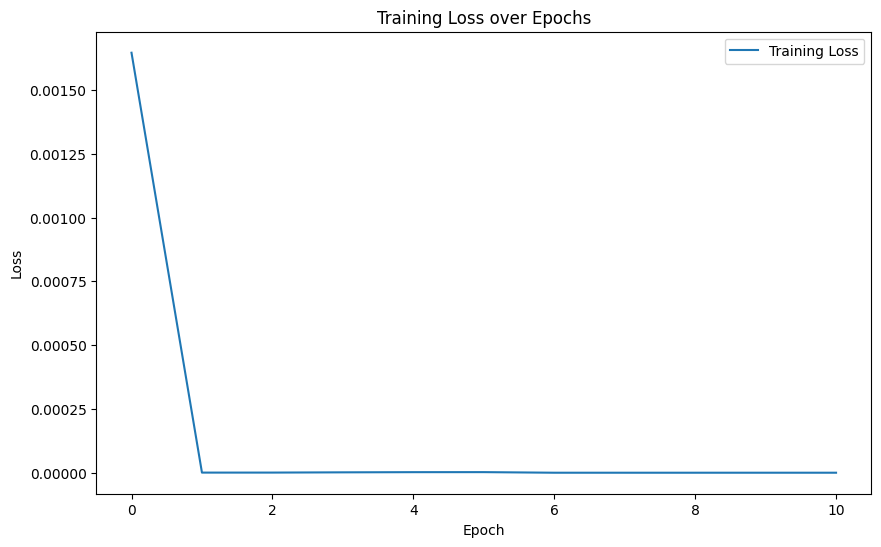

In [ ]:
# 손실 값 그래프 그리기
loss_history = deep_svdd.trainer.loss_history
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
deep_svdd.test(val_dataloader, device='cuda')
predictions = deep_svdd.predict(val_dataloader, device='cuda')


In [ ]:
from collections import Counter
counter = Counter(predictions)
print(counter)

Counter({False: 11959})


In [ ]:
# 테스트 데이터에 대한 예측
deep_svdd.test(test_dataloader, device='cuda')
test_scores = deep_svdd.trainer.test_scores

In [ ]:
# test_scores가 리스트 형태인 경우 이를 numpy array로 변환
test_scores = np.array(test_scores)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

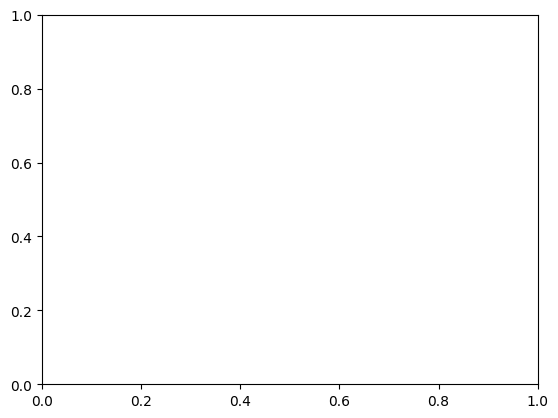

In [ ]:

# test_scores 분포 확인
plt.hist(test_scores, bins=50)
plt.title('Distribution of Test Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
threshold = np.percentile(test_scores, 95)  # 상위 5%를 이상치로 설정

In [ ]:
# test_df의 길이와 test_scores의 길이를 일치시키기 위해 인덱스를 조정하여 is_level_7 값을 설정
test_df['is_level_7'] = False
if len(test_scores) > len(test_df):
    test_scores = test_scores[:len(test_df)]

test_df.loc[test_df.index[:len(test_scores)], 'is_level_7'] = test_scores > threshold

In [ ]:
# 레벨 7로 분류된 데이터 출력
level_7_data = test_df[test_df['is_level_7']]['full_log']
print("Level 7 data:")
print(level_7_data)


Level 7 data:
Series([], Name: full_log, dtype: object)
